# This file computes syntactic complexity measures and bert embeddings for all essays in the ASAP #2 dataset, and builds a classification model to score the essays.
## Import library

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load data

In [2]:
loader = DataLoader()
d = loader.GetData('ASAP')
d = d.loc[d['essay_set'] ==2] # essay set starts from 0
d.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
1783,2978,2,Certain materials being removed from libraries...,4.0,4.0,NaN,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1784,2979,2,Write a persuasive essay to a newspaper reflec...,1.0,2.0,NaN,1.0,1.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,2980,2,Do you think that libraries should remove cert...,2.0,3.0,NaN,2.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1786,2981,2,"In @DATE1's world, there are many things found...",4.0,4.0,NaN,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1787,2982,2,In life you have the 'offensive things'. The l...,4.0,4.0,NaN,4.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extract embeddings
+ takes 19m27.4s on my computer in total
+ For performance reasons (out of memory), the dataset had to be processed in batches

In [ ]:
xc = []
xp = []
for i in range(0,2000,1000):
    if i == 2000:
        end = len(d)
    else:
        end = i+1000
    EmbeddingFetcher = GetBERTEmbeddings(d['essay'][i:end],'model/deberta-v3-large')
    EmbeddingFetcher.inf(stop=1000,SeqLen = 512)
    xp.append(EmbeddingFetcher.GetEmbeddings('MeanP'))
    xc.append(EmbeddingFetcher.GetEmbeddings('CLS')) 
    del EmbeddingFetcher
    torch.cuda.empty_cache()

### Save feature to disk

In [48]:
torch.save(xc,'features/asap-cls.pt')
torch.save(xp,'features/asap-meanp.pt')

## Fine-grained complexity features

In [ ]:
for i in d.index:
    t = d['essay'][i]
    if len(t) > 2:
        extractor = FeatureExtraction(t)
        extractor.process()
        features = extractor.get_data()
        with open('features/asap-fine.csv','a',encoding='utf-8') as f:
            f.write('{}, '.format(i))
            f.write(','.join([str(i) for i in features]))
            f.write('\n')
    else:
        with open('features/asap-fine.csv','a',encoding='utf-8') as f:
            f.write('{},'.format(i))
            f.write('\n')
    print(i)

## Classification model
### Prepare train and test data

In [49]:
from sklearn.preprocessing import LabelEncoder
xec= [np.array(i).reshape(1024) for i in xc] # cls embeddings
xep= [np.array(i).reshape(1024) for i in xp] # mean pooling embeddings
le = LabelEncoder()
le.fit(d['domain1_score'])
y = le.transform(d['domain1_score']) 
TrainY,TestY = y[:1400],y[1400:]

### Classification with CLS token

In [22]:
TrainX,TestX = np.array(xec[:1400]),np.array(xec[1400:])

In [28]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.67
0.6561814191660571


Text(50.722222222222214, 0.5, 'True Label')

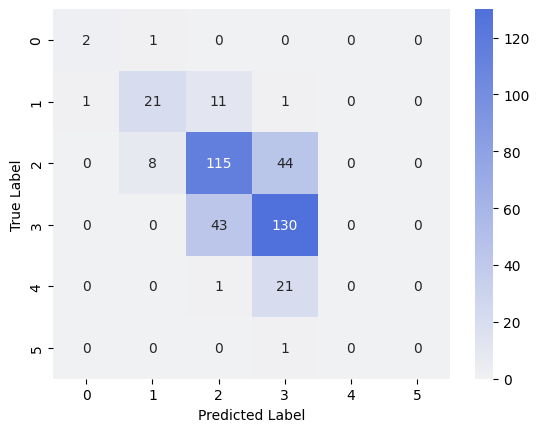

In [29]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')

### Classification with mean pooling

In [50]:
TrainX,TestX = np.array(xep[:1400]),np.array(xep[1400:])

In [53]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.6625
0.6298241008138619


Text(50.722222222222214, 0.5, 'True Label')

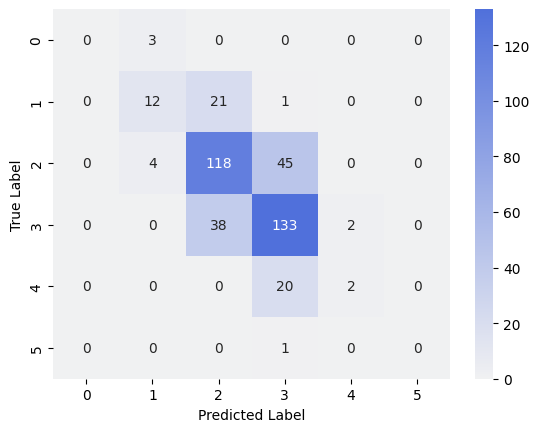

In [54]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')

### Classification with fine-grained complexity measures

In [57]:
xf = []
with open('features/asap-fine.csv') as f:
    for l in f.readlines():
        feat = [float(i) for i in l.split(',')[1:]]
        xf.append(feat)

In [60]:
TrainX,TestX = np.array(xf[:1400]),np.array(xf[1400:])

In [61]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.685
0.6880650994575046


Text(50.722222222222214, 0.5, 'True Label')

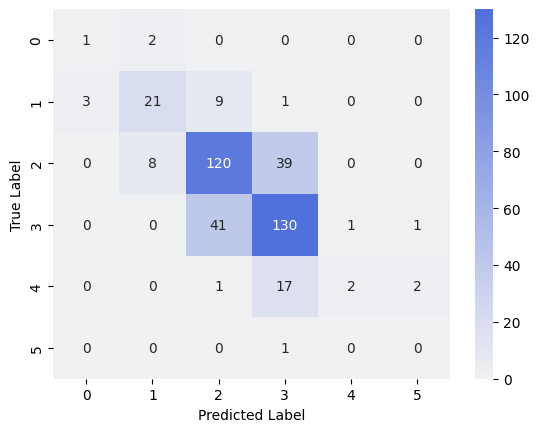

In [62]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')

### Classification with cls + fine-grained measures

In [64]:
xcf = []
for i in range(1800):
    a = np.concatenate((xec[i],xf[i]))
    xcf.append(a)
TrainX,TestX = xcf[:1400],xcf[1400:]

In [65]:
model = xgb.XGBClassifier(tree_method="hist",objective='multi:softmax',num_class=6,learning_rate=0.03)
model.fit(TrainX,TrainY)
PredY = model.predict(TestX)
print(accuracy_score(TestY,PredY))
print(cohen_kappa_score(TestY,PredY,weights='quadratic'))

0.6825
0.6821983273596177


Text(50.722222222222214, 0.5, 'True Label')

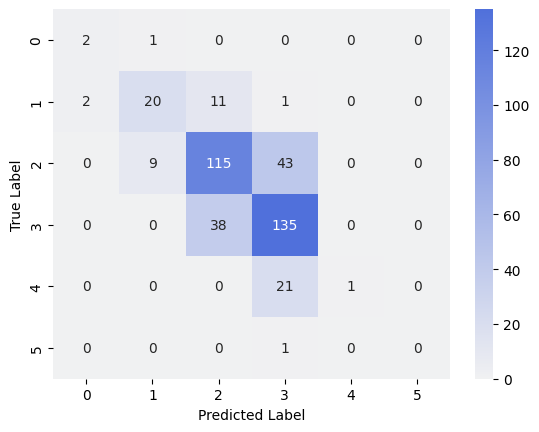

In [66]:
c = sns.light_palette((260, 75, 50),input = 'husl', as_cmap=True)
cm = confusion_matrix(TestY,PredY)
g = sns.heatmap(cm,annot=True,fmt='d',cmap=c)
g.set_xlabel('Predicted Label')
g.set_ylabel('True Label')